# A Brief Introduction to Julia Metaprogramming, Macros, and Generated Functions

### Purpose:

This Julia programming language notebook describes how to use Julia Metaprogramming, Macros, and Generated Functions through examples.

### Intended Audience:
Julia programmers and enthusiasts 


### Important Information about this notebook

**Julia Version of this notebook:** *Julia 0.6.2*



**References Used To Build This Notebook:**
* Julia 1.0 Programming by Ivo Balbaert ISBN:9781788999090

* Julia: High Performance Programming by Malcolm Sherrington, Avik Sengupta, Ivo Balbaert ISBN:9781787125704

* Julia Documentation on-line : https://docs.julialang.org/en/v1/


In [26]:
# Revealing the present Julia programming language version
VERSION

v"0.6.2"

## Metaprogramming in Julia

Everything in Julia is an *expression* that returns a value when executed. In fact, every piece of program code is internally represented as an ordinary Julia data structure, referred to as an *expression*. 

By working with *expressions*, a Julia program can transform and even generate new code.  This capability is referred to as **homoiconicity**. Homoiconic languages allow code to be expressed in terms of that language's syntax. Namely, Julia is able to generate brand new "Julia" code during runtime, and this newly minted code can subsequently be executed.

Don't worry, it is all going to make sense in a few more minutes. Keep reading!

## Expressions and Symbols

An **Abstract Syntax Tree (AST)** is a tree representation of the abstract syntactic structure of the the source code written in the Julia programming language. When Julia code is parsed by its LLVM Just-In Time (JIT) compiler, it is internally represented as an abstract syntax tree.


Let's look at an example of a tree.

An expression is simply an object that represents Julia code. 

For example, 
``2+3``

is a piece of code which is an expression of type

``Int64.``

Its **syntax tree** looks like the figure below. 


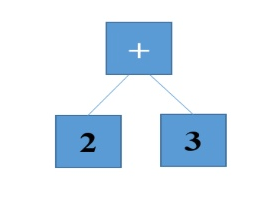

In [27]:
#Pkg.add("FileIO") # In case you do not have FileIO installed 
using FileIO   # Let's us load some figures into cells
img = load("meta1_fig.png")

To make Julia see 2+3 as an expression and block its evaluation immediately (i.e., keep the expression from being executed to render a result), it must be **quoted**. Quoting happens in two ways. For this single one-liner, we would make 2+3 an *expression* by preceding it with a colon **\:** as in **:(2+3)**. The colon is known as the **quote** operator. It treats the argument as data, not as code. 

In the context of an expression, symbols are used to indicate access to variables; they represent the variable in the tree structure for the code. The two **quote** operators **\:** and (**quote...end**) prevent evaluation. For instance  x = 5 will return 5, but **:x** will return **:x** at a Julia REPL line as shown in the cells below.


In [28]:
x = 5

5

In [29]:
:x

:x

When we evaluate **:(2+3)** in the REPL, it just returns **:(2+3)** which is of type Expr, Expression. 


In [30]:
:(2+3)

:(2 + 3)

In [31]:
typeof(:(2+3))

Expr

Now, if you do not have a one-liner *expression* (i.e., the *expression* spreads across multiple lines), we would simply **quote** the entire multi-line expression using **quote** and **end** block enclosures. Check it out.



In [32]:
quote
    a = 42 
    b = a^2
    a-b
end


quote  # In[32], line 2:
    a = 42 # In[32], line 3:
    b = a ^ 2 # In[32], line 4:
    a - b
end

In [33]:
# note: you could have done this in one long one-liner equivalent
:(a=42; b=a^2; a - b)

quote 
    a = 42
    b = a ^ 2
    a - b
end

*Expressions* can be named/assigned similar to how we assign *variables* a name. 

Additionally, we can acquire other information about the *expression*, which reveals that *expressions* are made up **symbols** and **literals**.  Complex *expressions* will consist of literal values, symbols, and sub or nested *expressions*, which can similarly be broken down to symbols, literals, and possible nested *expressions*, and broken down further as necessary until you arrive at only symbols and literals. 


In [34]:
e1 = :(2+3)

:(2 + 3)

In [35]:
e1.head

:call

In [36]:
e1.args

3-element Array{Any,1}:
  :+
 2  
 3  

* **e1.head** returns **:call** indicating the kind of expression, which in this *expression* is a function **call**

* **e1.args** returns the elements of the expression in an array. 
    * consists of a symbol,  **:+**
    * and two literal values: 2 and 3
    

### Example of a Complex Expression

Here's a complex expression
``` e2 = :(2 + a * b - c)```

A simple graphical visualization


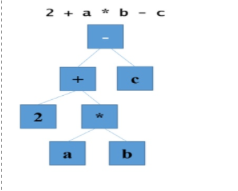

In [37]:
img = load("meta2_fig.png")

In [38]:
# Defining the complex expression in Julia

e2 = :(2 + a * b -c)


:((2 + a * b) - c)

In [39]:
# the type of expression found using .head
e2.head

:call

In [40]:
# the symbols, literals, and possible sub expressions using .args
e2.args

3-element Array{Any,1}:
 :-          
 :(2 + a * b)
 :c          

To see the *abstract syntax tree (AST)*, we can use the Julia **dump** function

In [41]:
dump(:(2 + a * b -c))

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol -
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Int64 2
        3: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: Symbol *
            2: Symbol a
            3: Symbol b
          typ: Any
      typ: Any
    3: Symbol c
  typ: Any


### BUT WAIT! 

There is one more way to build *Expressions* : Use the Expr **constructor** 

(see terminology definition at the end of this notebook to understand a constructor)

In [42]:
e1 = Expr(:call, *, 3, 4)

:((*)(3, 4))

In [43]:
?Expr

search: Expr export nextprod expanduser expm exp2 exp expm1 exp10 expand



No documentation found.

**Summary:**

```
mutable struct Expr <: Any
```

**Fields:**

```
head :: Symbol
args :: Array{Any,1}
typ  :: Any
```


## Evaluation and Interpolation

So, up to this point we have learned how to use **quoting** (**\:** or **quote..end**) and **Expr** constructors to build expressions, Julia code essentially built from within Julia code. The question you are no doubt asking now is *"How to execute these expressions to make expression realizable code?"* Hang on true believers cause we got you covered in this section.

#### Evaluation--How We Execute an Expression:

The result of an expression can be computed with the **eval** function!
Say we take our e1 = Expr(:call, *, 3, 4) *expression*: use *eval(e1)* and voila!, The value *12* gets returned.

In [44]:
e1 = Expr(:call, *, 3, 4)


:((*)(3, 4))

In [45]:
#Execute expression e1
eval(e1) 

12

#### All symbols Need to be Defined at Execution:
Key point: at the time an *expression* is constructed, not all the symbols have to be defined, but they have to be at the time of evaluation (i.e., when **eval()** is invoked), otherwise errors occur.


In [46]:
# Example of this error situation
e2 = Expr(:call, *, 3, :a)

eval(e3) #evaluation of e3 has error because a is not assigned

1

In [47]:
# The fix 
# We would have to assign a value to "a", and then evaluate "e2" before we would 
# return a value.

e2 = Expr(:call, *, 3, :a)
a = 4
eval(e2) #evaluation of e3 has error because a is not assigned

12

#### Expressions Can Change State of the Execution Environment:

expression **e3** assigns a value to variable b when the expression **e3** gets evaluated. It might even define b, if it does not already exist.


In [48]:
e3 = :(b = 1)

:(b = 1)

#### Interpolation – Immediate Evaluation of an Expression and Tool to Make Writing Expressions Easier:

To interpolate, we use the **\$** operator in an expression. Similar to how we use the **\$** operator with strings, the **\$** operator will evaluate immediately when the *expressions* are made (not evaluated). Check it out below.

In [49]:
a = 1
b = 99
e4 = :(a + b);
e5 = :($a + b);

In [50]:
e4

:(a + b)

In [51]:
e5

:(1 + b)

In [52]:
eval(e4)

100

In [53]:
eval(e5)

100

We see that with **e5** that **\$a** gets immediately evaluated in the *expression* to get value **a = 1**. Both **e4** and **e5** both evaluated return the same value of **100**.

#### Conclusion:

There are two kinds of evaluations:

* Expression interpolation (with **\$**) evaluates when the *expression* is constructed (at *parse time*)

* Quotation (with **\:** or **quote..end**) evaluates only when the *expression* is passed to **eval** at runtime.


## Defining Macros

Up until now, we have restricted our discussions primarily around the topic of *Expressions*. In this section, we bring it altogether by introducing the concept of *Macros*.

*Macros* are like functions, but instead of values, they take-in *expressions* (i.e., symbols and literals) as input arguments. When a *macro* is evaluated, the input *expression* is expanded, meaning the macro returns a modified expression. This expansion occurs at parse time when the syntax tree is being built, NOT when the code is actually executed.

Again the differences between functions and macros when they are called or invoked are:

* **Function**: takes the input values and returns the computed values at *runtime*.

* **Macro**: takes the input expression and returns the modified expressions at parse time. Macros are a form of custom program transformation

### Macro Definition

**macro mname**

    #code returning expression

**end**

here the *Macro* block defines a new scope which is why we have to use some special syntax for defining local variables. 

Macros allow us to control when the code is executed.


#### The Calling Context: When the Macro Gets Invoked

**@mnanme exp1 exp2 or @mname(exp1,exp2)**

here the **@** sign distinguishes a macro from a normal function

##### Example 1: Showing Definition and Invocation of a Macro

Notice that we use **$** interpolation to immediately evaluate the expression **ex**

**ex** is 

`println("Second")`

**$ex** immediately evaluates the expression resulting in *Second* to be inserted tinto the **quote** block. 


In [54]:
macro macex1(ex)
    quote
        println("First")
        $ex
        println("Third")
    end
end

@macex1 (macro with 1 method)

In [55]:
@macex1 println("Second")

First
Second
Third


##### Example 2: Showing How a Macro Can Be Expanded Showing a Resulting Expression

The **assert** macro to the left takes an expression, **ex**, and tests whether it is true or not. 

The macro replaces the expression with a ternary operator expression, which is evaluated at runtime. To examine the resulting expression, use the **macroexpand** function.

In [56]:
macro assert(ex)
    :($ex ? nothing : error("Assert failed: ", $(string(ex))))
end


@assert (macro with 1 method)

In [57]:
@assert 1 == 42

LoadError: [91mAssert failed: 1 == 42[39m

In [58]:
macroexpand(:(@assert 1==42))

:(if 1 == 42
        Main.nothing
    else 
        (Main.error)("Assert failed: ", "1 == 42")
    end)

#### Macro Scope and Context 

When you are using *macros*, it is important to keep an eye out for scoping issues.

Let's take a look at the escape function, **esc**, with  **\$(esc(ex))**.

In [59]:
macro f(x)
    quote
        s = 4
        (s, $(esc(s)))
    end
end


@f (macro with 1 method)

This macro declares a variable `s`, and returns a **quoted** expression containing `s` and an escaped version of `s`. 

notice also the implicit return (i.e., last line executed return value(s)) at 
`(s,$(esc(s)))` 

In [60]:
s = 0 # Now, outside the macro, declare a symbol s:

0

Run the macro like in the cell below.

The macro returns different values for the symbols `s:`, the first was the value inside the macro's context, `4`  the second was an escaped version of `s`, that was evaluated in **the calling context** (the **@f 2**part), where `s` has the value `0` established in the  `s= 0` line julia REPL command line above. 

The `2` in **@f 2** is just ignored or meaningless here as we did not use it in the macro **quote** block. 

In a sense, **esc()** has protected the value of `s` as it passes unharmed through the macro. 


In [61]:
@f 2

(4, 0)

#### Macros Should be Hygienic 

We are not talking clean here. Unlike functions, macros inject code directly in the namespace in which they are called, possibly this also in a different module than in which they were defined. It is therefore important to ensure that this generated code does not clash with the code in the module in which the macro is called.

It is about differentiating between the macro context and the calling context. 

When a macro behaves appropriately like this, it is called a **hygienic macro**.

*Hygienic Macro Rules:*

1. Declare variables used in the macro as **local** - prevents conflict with other variables

2. Use the escape function **esc** to make sure that an interpolated expression is not expanded, but instead is used literally

3. Don't call **eval** inside a macro (because it is likely that the variables you are evaluating don't even exist at that point)


##### A Good Example of a Hygienic Macro is the timeit Macro

The expression, **ex**, is executed through **\$**, and **t0** and **t1** are respectively the start and end times. 

In [62]:
macro timeit(ex)
    quote
        local t0 = time()
        local val = $(esc(ex))
        local t1 = time()
        println("elapsed time in seconds: ")
        @printf "%.3f" t1-t0
        val
    end
end

@timeit (macro with 1 method)

Here, the **\$esc(ex))** expression allows you to 'escape' the code you want to time, which is in **ex**, so that it isn't evaluated in the macro, but left intact until the entire **quoted** expression (everything between the **quote and end**) is returned by `@timeit` macro is evaluated at **the calling context** and executed there.

An expression wrapped in this manner is left alone by the macro expander and simply pasted into the output verbatim. It will be resolved in the macro call environment.

In the timeit macro example, it was important to make sure that the expression you want to time is not modified in any way by the macro.


In [63]:
@timeit factorial(10)

elapsed time in seconds: 
0.004

3628800

## Generated Functions

Generated functions (also sometimes called staged functions) take advantage of a special macro **@generated**, This special macro allows you to define so-called generated functions. These have the capability to generate specialized code depending on the types of their arguments with more flexibility and/or less code than what can be achieved with multiple dispatch. 

So, how do they relate to macros and expressions and pretty much everything we have discussed so far.

Answer. While, macros work with expressions at parse time and cannot access the types of their inputs, a generated function gets expanded at a time when the types of the arguments are known, but the function is not yet compiled. 

Here is where it gets a little deep, so hold on.

Instead of performing some calculation or action, a generated function declaration returns a **quoted** expression which then forms the body for the method corresponding to the types of the arguments. Generated functions are invoked once for each unique type of its arguments. As this point, arguments themselves take the values of their types.

The return value of this execution must be an expression that is used as the body of the function when called with values of these types. So, when a generated function is called, the expression it returns is compiled and then run. 

This cycle is executed each time the function I called with new types: the function is called with types as values once, and then the returned expression is used for all invocations with argument values of this type. Julia makes this process ultra efficient by caching the resulting expression from compilation with the argument values of specific type. 

### Performance Improvements with Generated Functions

Julia's generated functions provide a flexible way to move work from run time to compile time. As with macros, generated functions improve performance by moving constant parts of the computation earlier in the compilation stage. However, the big difference between generated functions and macros is that computations are fixed only for a certain type of argument for generated functions. Again, going back to the idea of expression being cached for functions using particular argument types. For different types of arguments, the computations are different. 

#### Defining Generated (Staged) Functions

1. The function declaration MUST be annotated with the **@generated** macro. This declaration places information into the Abstract Syntax Tree which lets the compiler know that this is a generated function.

2. In the body of the generated function you only have access to the *types* of the arguments – not their values --and any function that was defined before the definition of the generated function.

3. Instead of calculating a result and returning the result like in a typical function, generated functions only return a **quoted** expression, which when evaluated, performs the calculation and returns a result as desired with the given arguments.

4. Generated functions MUST NOT mutate or observe any non-constant global state, meaning they can only read global constants and cannot have any side effects. Generated function have to be completely pure. PURE in the sense that as of the time of this writing, they cannot define a closure or generator.

The following examples should help with understanding.

#### Example 1: Simple Generated Function 

The body of the generated function simplegen returns a quoted expression, `:(x * x)` and not the value of  `x * x`.

Note: the generated function actually contains side-effects, the call to Core.println. It does not define exactly when, how often, or how many times these side-effects occur.  It is used here just to show a simple example of how a generated function would work. It is not an ideal example, so do not use this in your real code. (wink)


In [64]:
@generated function simplegen(x)
    Core.println(x)
    return :(x * x)
end

simplegen (generic function with 1 method)

The call to the simplegen generated function is identical to a regular function.  

The call shows that the `println` statement is executed and then the returned expression is evaluated using the *Int64* value of 2.  

You see that in the body of the generated function, `x` is the type of passed argument, and the value returned by the generated function is the result of evaluating the **quoted** expression we returned from the definition, now with the value of `x`.

In [65]:
#Output is from the println() statement in the return of the expression being evaluated
x = simplegen(2) 

Int64


4

`x` equals the value of the returned evaluated expression with the input from  simplegen(2) 


In [66]:
x

4

Here is an example showing a **String** input with the multiplication symbol showing concatenation of the strings.

In [67]:
y = simplegen("Aloha")

String


"AlohaAloha"

In [68]:
y

"AlohaAloha"

#### Example 2: Evaluating the Same Generated Function with Type Previously Used

This time there is no printout of the **Int64** . Only the body of the generated function was executed once here, for the specific set of arguments types. The resulting returned expression `:(x * x)` was cached, so that after `simplegen(2)` the generated function was re-used as the method body for type *Int64* parameter during this second attempt of `simplegen(4)`. 

**Here is the point**. The number of times a generated function is err, well, generated, might be more than once, so it it is important to never generate a function with side effects 

In [69]:
simplegen(4)

16

#### Example 3: Generated functions and Method Redefinitions

`origfunc(x)` has one definition.

In [70]:
origfunc(x) = "original definition"

origfunc (generic function with 1 method)

Define other operations that use `origfunc(x)`

Check out `@generated` functions

In [71]:
copyorigfunc(x) = origfunc(x);

In [72]:
@generated gen1(x) = origfunc(x);

In [73]:
@generated gen2(x) = :(origfunc(x));

Now we add new definitions for `origfunc(x)`

In [74]:
origfunc(x::Int) = "definition for Int";
origfunc(x::Type{Int}) = "definition for Type{Int}";

In [75]:
# origfunc(1) - here we see the new definition using an Integer 
#               argument takes precedence.
origfunc(1)

"definition for Int"

In [76]:
# copyorigfunc(1)  - follows from the assignment of copyorigfunc = origfunc 
#                    they point to the same place in memory.
copyorigfunc(1)

"definition for Int"

In [77]:
# gen1(1) - follows the origfunc(x) prior to the new 
#          definition of origfunc(x) 
gen1(1)

"original definition"

In [78]:
# gen2(1) - uses a quoted version of origfunc(x) which 
#           follows the latest definition during call invocation.
gen2(1)

"definition for Int"

### How generated functions have there their own view of defined functions 

here `gen1(x::Real) = origfunc(x)`  in the cell below

shows that we can use the *type* of argument for a generated function to dictate the *type* of *expression* rendered as the resulting *expression* of the generated function by choosing the appropriate defined *function* by the *type* of input for the defined function. 

Type `Real` dictates the expression resulting as we see in the cells below.

In [79]:
@generated gen1(x::Real) = origfunc(x);

In [80]:
gen1(1)

"definition for Type{Int}"

## Terminology

**compile time** - the instance when the code you have entered gets converted to an executable.

**constructor** - Constructors in Julia programming are functions that create new objects – specifically of composite types. According to the Julia Docs,(https://docs.julialang.org/en/v1/manual/constructors/index.html#footnote-1) 

```While the term "constructor" generally refers to the entire function which constructs objects of a type, it is common to abuse terminology slightly and refer to specific constructor methods as "constructors". In such situations, it is generally clear from the context that the term is used to mean "constructor method" rather than "constructor function", especially as it is often used in the sense of singling out a particular method of the constructor from all of the others.``` 

**homoiconicity** - (from the Greek words *homo*- meaning "the same" and *icon* meaning "representation"). In computer programming, homoiconicity is a property of some programming languages. A language is homoiconic if a program written in it can be manipulated as data using the language, and thus the program's internal representation can be inferred just by reading the program itself.

**hygienic** - An appropriately behaving MACRO is called a hygienic macro. Hygiene with macros is all about differentiation between the macro context and the calling context.

Hygienic Macro rules:

* Declare variables used in the macro as local - prevents conflict with other variables

* Use the escape function **esc** to make sure that an interpolated expression is not expanded, but instead is used literally

* Don't call **eval** inside a macro (because it is likely that the variables you are evaluating don't even exist at that point)

**parse time** - when the code syntax is analyzed 

**runtime** - the instance where executable code is running. 